<a href="https://colab.research.google.com/github/Dangandy/mejuri-classifier/blob/master/Mejuri_Image_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

We are tasked to classify images uploaded by clients and recommend a mejuri product

# Import

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate # 1 - accuracy

In [0]:
import pandas as pd

# Preprocess

## Web scrape

We will be using selenium's webdriver to scrape mejuri's website and beautiful soup to parse the html page scraped.



### Set up

In [28]:
!pip install selenium
!pip install bs4

     |████████████████████████████████| 911kB 4.8MB/s 


In [29]:
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [83.6 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/multiv

In [0]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium import webdriver
from bs4 import BeautifulSoup
import sys
import time

In [0]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

### Scrape

Note: the images retreived are of low resolution 🙃

In [0]:
# Variables
path = '/content/drive/My Drive/1000 ML/Project 6'

urls = [
     'https://mejuri.com/shop/t/type/earrings',
     'https://mejuri.com/shop/t/type/rings',
     'https://mejuri.com/shop/t/type/pendants',  # Necklaces
     'https://mejuri.com/shop/t/type/bracelets'
]

categories = [
              'earring',
              'ring',
              'necklace',
              'bracelet'
]


In [46]:
# Code is broken because the filename is not dynamic
for url, category in zip(urls, categories):

  # get progress..
  print(f'retreiving {category} @ {url}')

  # Chrome options
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  browser = webdriver.Chrome('chromedriver',options=chrome_options)

  # get..
  browser.get(url)

  last_height = browser.execute_script("return document.body.scrollHeight")
  while True:
      # Scroll down to bottom
      browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      # wait to load page
      time.sleep(30)
      # Calculate new scroll height and compare with last scroll height
      new_height = browser.execute_script("return document.body.scrollHeight")
      if new_height == last_height: # which means end of page
          break
      # update the last height
      last_height = new_height

  # Remember to quit or you will be blocked by mejuri!!
  html_page = browser.page_source
  browser.quit()

  # parse 
  soup = BeautifulSoup(html_page)
  containers = soup.findAll('div', {'class': 'category-product'})

  # save info into arrays
  product_links = [ f'https://mejuri.com{container.div.a.attrs["href"]}' for container in containers]
  titles = [container.h2.get_text() for container in containers]
  prices = [container.p.get_text() for container in containers]
  image_links = image_links = [container.findAll('img')[0]['data-src'] for container in containers]

  # Save into csv
  ring = pd.DataFrame(data=list(zip(titles, prices, product_links, image_links)), columns=['Title', 'Price', 'Product', 'Image'])
  ring.to_csv(f'{path}/{category}.csv')

retreiving earring @ https://mejuri.com/shop/t/type/earrings
retreiving ring @ https://mejuri.com/shop/t/type/rings
retreiving necklace @ https://mejuri.com/shop/t/type/pendants
retreiving bracelet @ https://mejuri.com/shop/t/type/bracelets


### Download images for scraping

In [0]:
import urllib

#### Download images

In [48]:
download_root_path = '/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/mejuri'
path = '/content/drive/My Drive/1000 ML/Project 6'
for category in categories:

  print(f'Starting download for {category}')
  csv = f'{path}/{category}.csv'
  download_path = f'{download_root_path}/{category}'

  df = pd.read_csv(csv, index_col=False)

  for i in range(len(df.Image)):
    filename = f'{download_path}/{category}{i}.png'
    local_filename, headers = urllib.request.urlretrieve(df.Image[i], filename)
    html = open(local_filename)
    html.close()

  print(f'Finished downloading {i} for {category}')

Starting download for earring
Finished downloading 114 for earring
Starting download for ring
Finished downloading 76 for ring
Starting download for necklace
Finished downloading 87 for necklace
Starting download for bracelet
Finished downloading 31 for bracelet


# Build Model

## Train Model

train our model with fastai.. code is sourced from the fastai course lectures

Note: training should only take 2 seconds to run on colab, make sure to turn on GPU

Note 2: there's more GPU on weekends

In [0]:
# Training parameters
bs = 64
# bs = 16  # if colab doesn't support 64 with resnet50

# paths
path = '/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/Jewellery'

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path,
    train='.',
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=128,
    num_workers=4,
    bs = bs
).normalize(imagenet_stats)

In [5]:
data.classes

['bracelet', 'earring', 'necklace', 'ring']

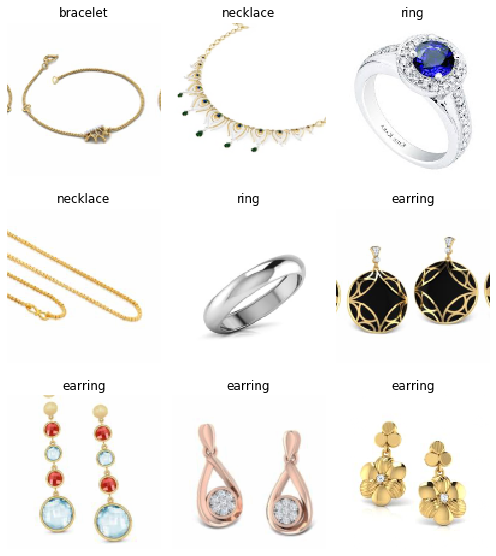

In [6]:
data.show_batch(rows=3, figsize=(7, 8))

In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


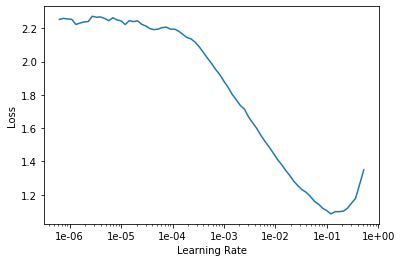

In [8]:
lr_find(learn)
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(10, slice(3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,1.642513,0.469681,0.165354,00:37
1,0.982733,0.102129,0.047244,00:08
2,0.647502,0.093509,0.039370,00:08
3,0.476052,0.133149,0.047244,00:08
4,0.365128,0.083175,0.023622,00:07
5,0.284160,0.070992,0.019685,00:07
6,0.234453,0.073237,0.015748,00:08
7,0.183841,0.067488,0.023622,00:08
8,0.147798,0.068178,0.023622,00:08
9,0.125908,0.065926,0.019685,00:08


In [10]:
learn.save('/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/stage-1')
learn.load('/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1017 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
ring,ring,ring,ring,ring
Path: /content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/Jewellery;

Valid: LabelList (254 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
bracelet,bracelet,earring,bracelet,necklace
Path: /content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/Jewellery;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1):

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

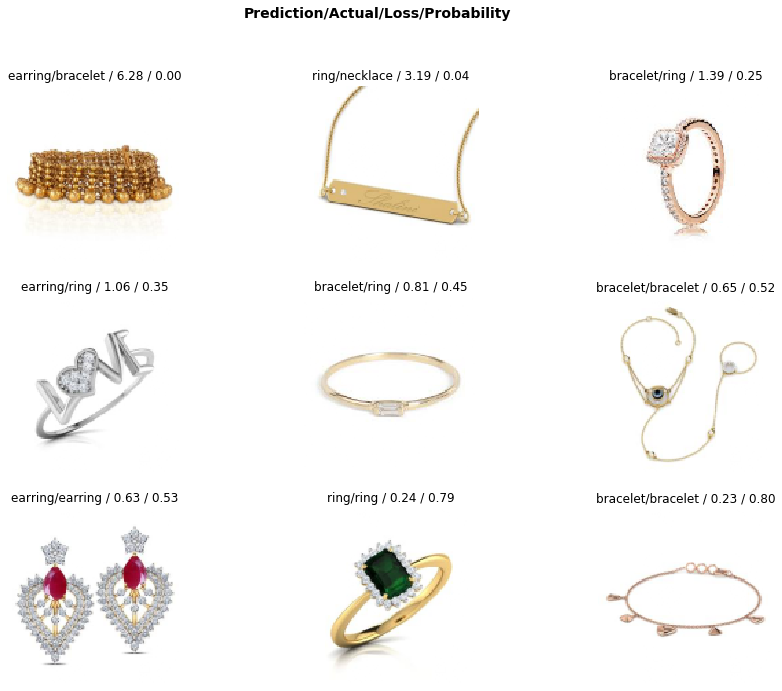

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

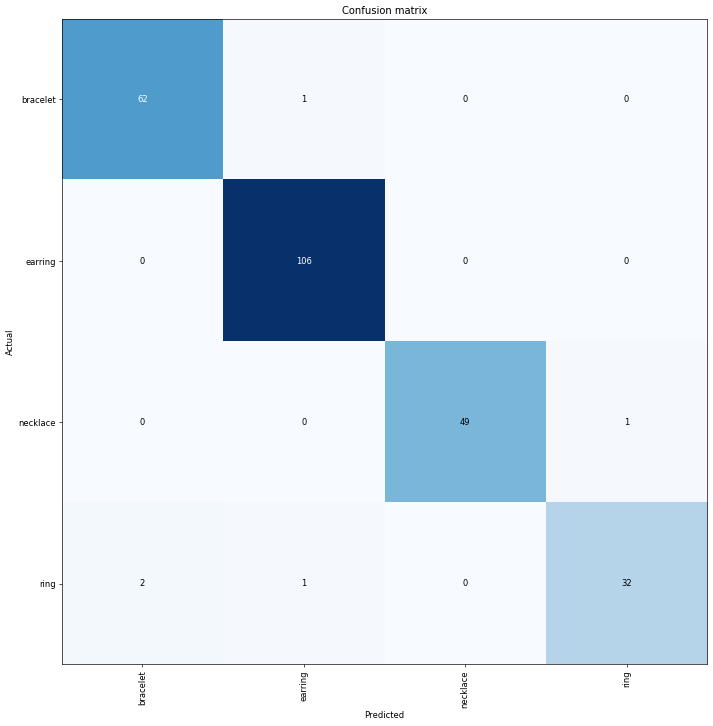

In [13]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path,
    train='.',
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=256,
    num_workers=4
).normalize(imagenet_stats)

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


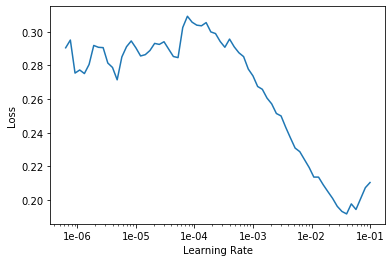

In [16]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [17]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.222823,0.098418,0.043307,00:10
1,0.145193,0.075988,0.035433,00:10
2,0.120252,0.080072,0.019685,00:10
3,0.096935,0.077445,0.015748,00:10
4,0.087400,0.064625,0.019685,00:10


In [18]:
learn.save('/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/stage-2')
learn.load('/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (1017 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
ring,ring,ring,ring,ring
Path: /content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/Jewellery;

Valid: LabelList (254 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
bracelet,bracelet,earring,bracelet,necklace
Path: /content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/Jewellery;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1):

Text(0.5, 1.0, 'Losses over time')

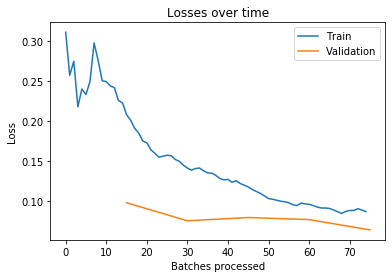

In [19]:
learn.recorder.plot_losses()
plt.title('Losses over time')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


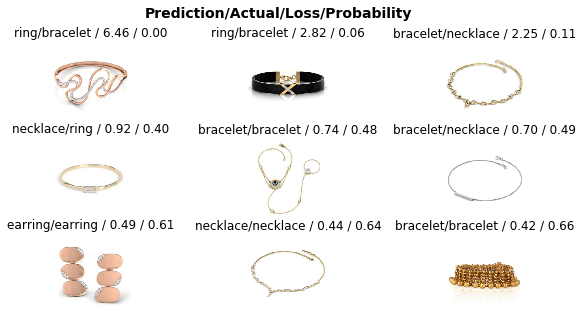

In [21]:
interp.plot_top_losses(9, figsize=(10,5))

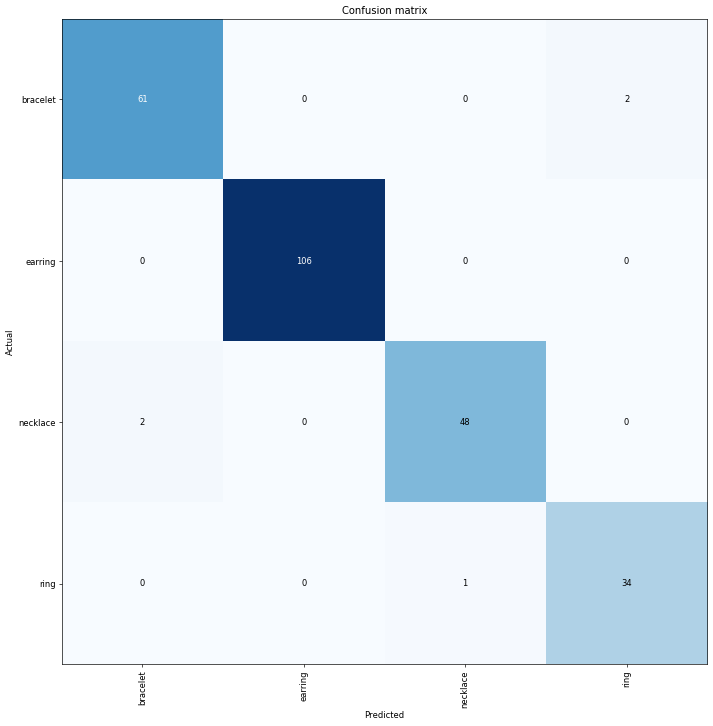

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Train Model Again

In [0]:
path = '/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/mejuri'

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path,
    train='.',
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4
).normalize(imagenet_stats)

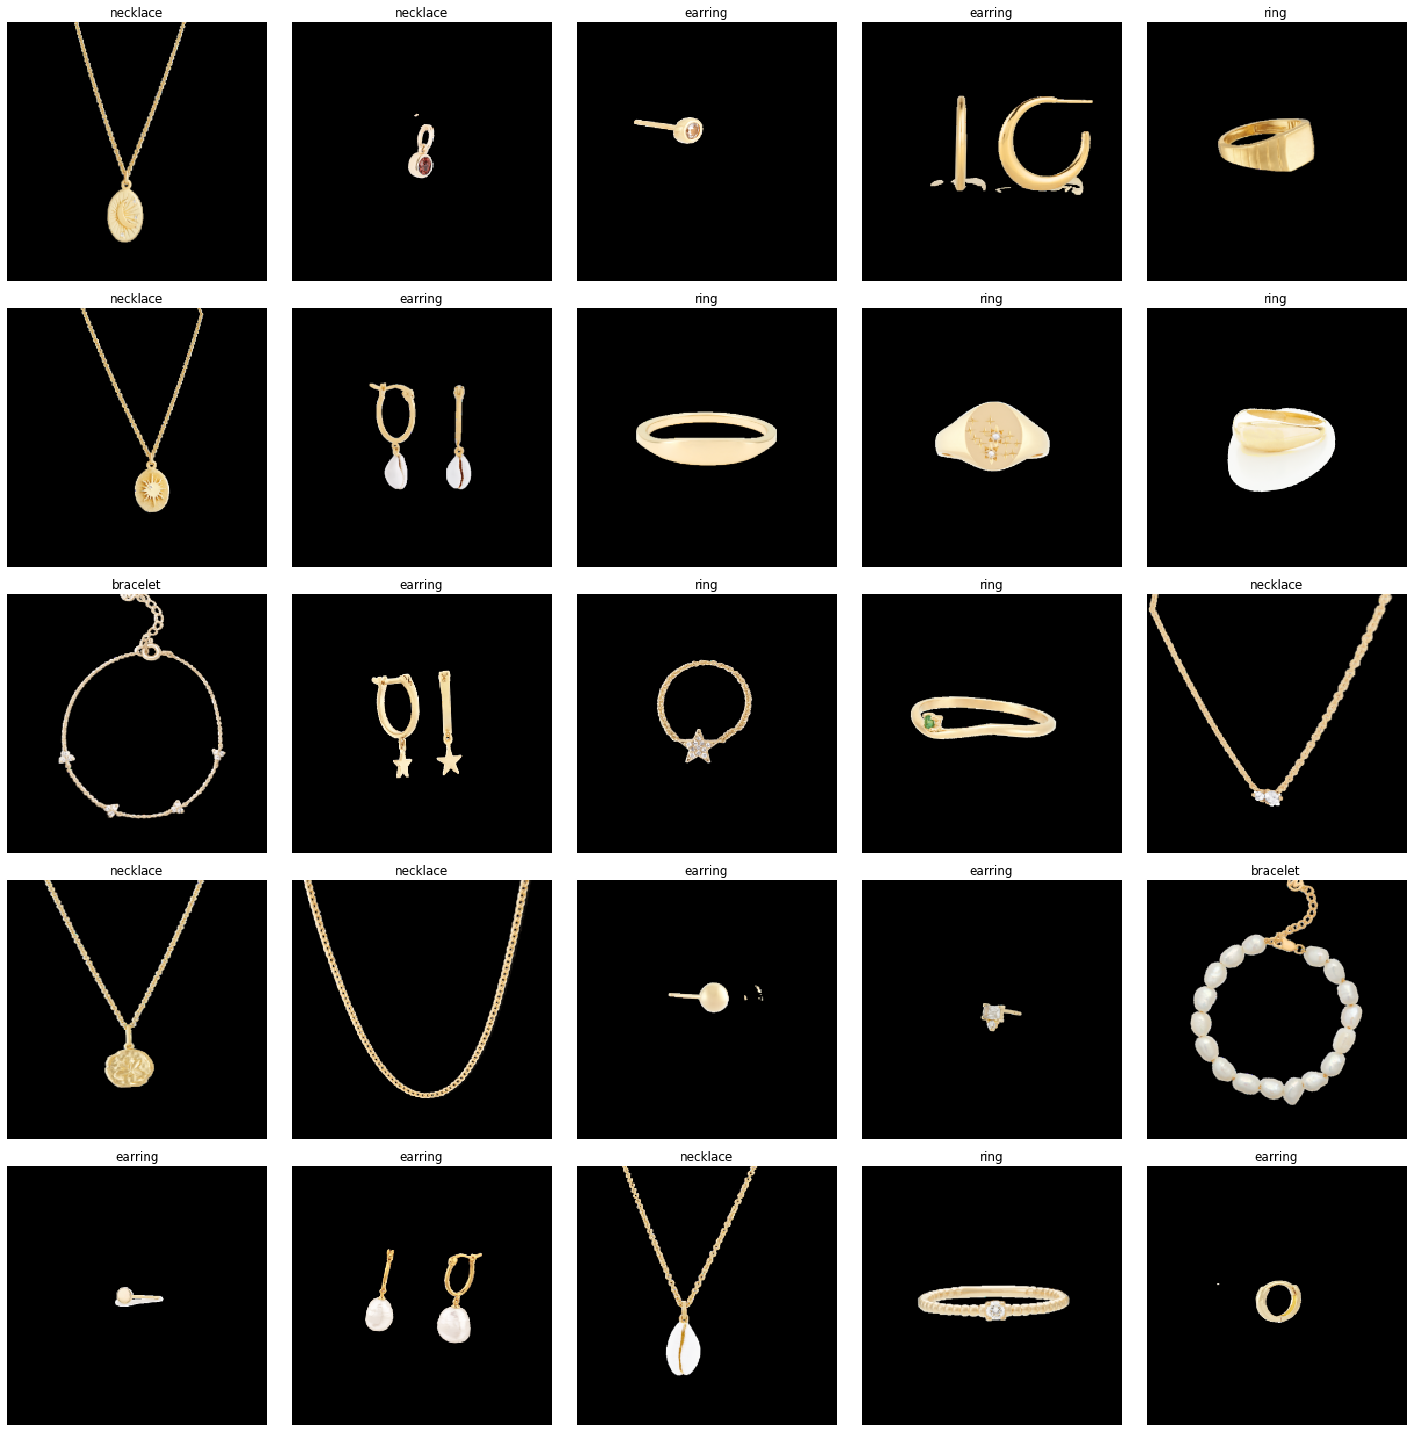

In [51]:
data.show_batch()

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


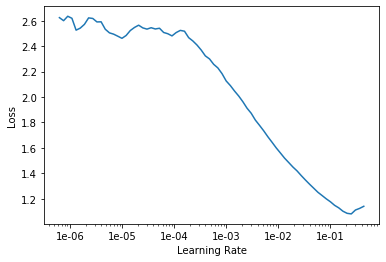

In [53]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(10, slice(1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,3.130360,4.047657,0.516129,00:06
1,2.724940,3.128957,0.435484,00:06
2,2.379156,2.312790,0.370968,00:06
3,2.040617,1.579495,0.258065,00:06
4,1.733540,1.241073,0.161290,00:06
5,1.544638,0.965243,0.161290,00:06
6,1.376774,0.455224,0.112903,00:06
7,1.257605,0.369470,0.064516,00:06
8,1.161726,0.384934,0.064516,00:05
9,1.096755,0.420011,0.064516,00:06


In [0]:
learn.save('/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/stage-3')

# Build Recommendation

## Hooks

In [0]:
from fastai.callbacks.hooks import *
import time

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [0]:
sf = SaveFeatures(learn.model[1][4])

In [58]:
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [0]:
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]

In [0]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})

In [0]:
array = np.array(sf.features)
x=array.tolist()
df_new['img_repr'] = x

## Cosine Similarity

In [0]:
from scipy.spatial.distance import cosine

In [0]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

In [0]:
def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - df_new['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [64]:
base_image, base_label, similar_images_df = get_similar_images(0)

0.05411362648010254 secs


ring
/content/drive/My Drive/1000 ML/Project 6/Jewellery.tar.gz (Unzipped Files)/mejuri/ring/ring3.png


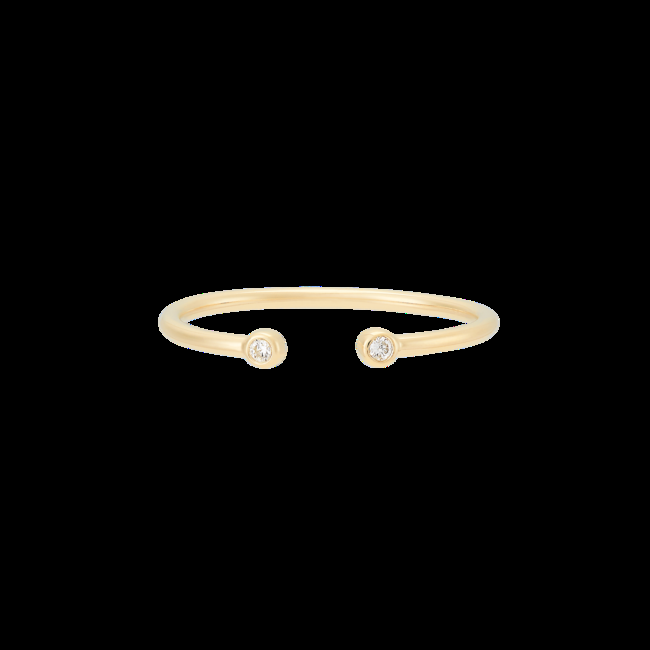

In [65]:
print(base_label)
print(base_image)
open_image(base_image)

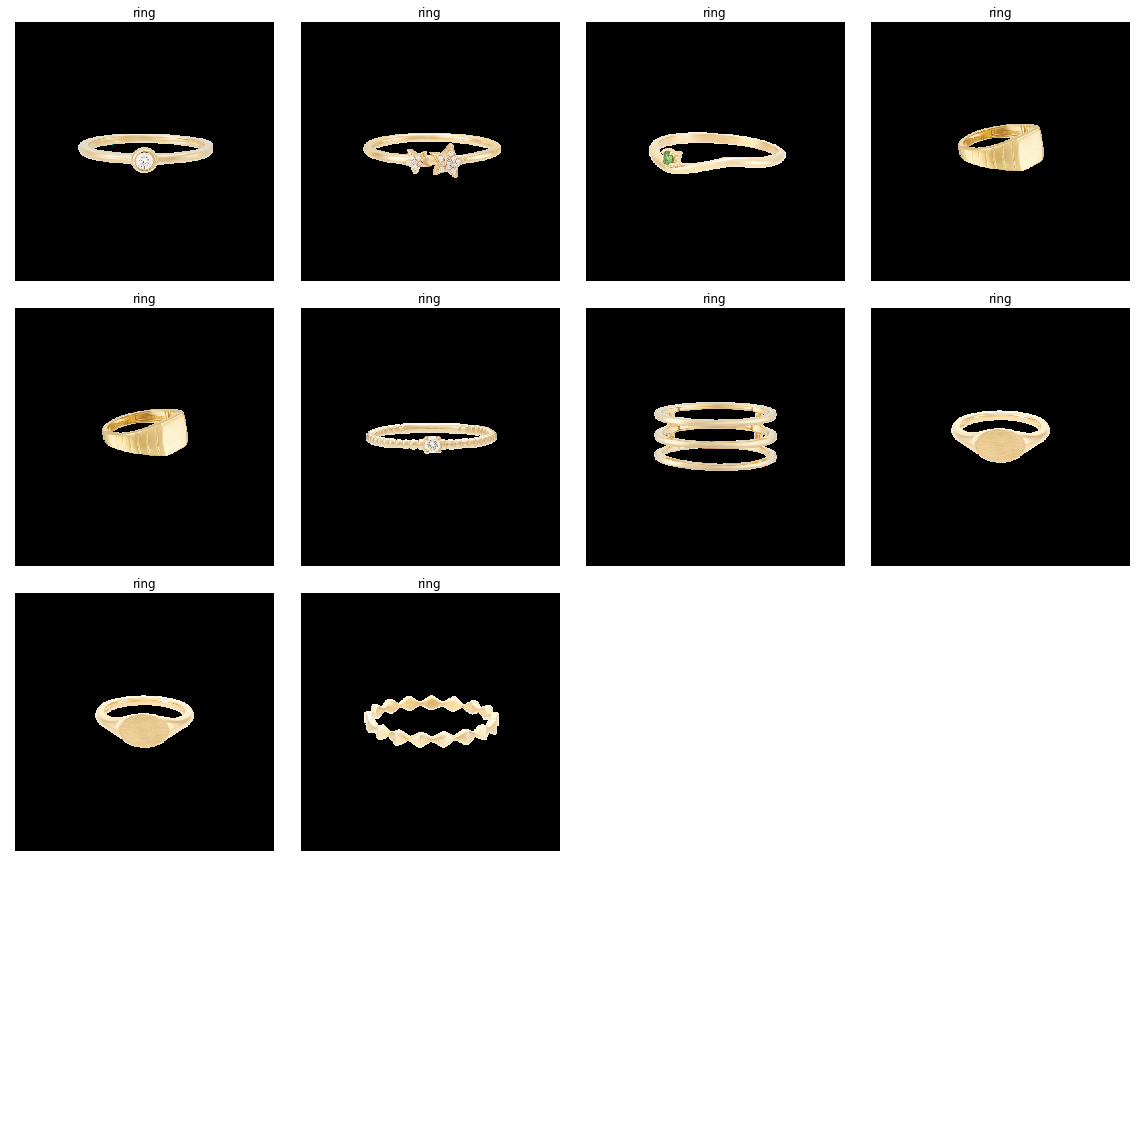

In [68]:
show_similar_images(similar_images_df)